### Factor Analysis using the CAPM and Fama-French Factors models

The main idea in Factor Analysis is to take a set of observade returns and decompose it into a set of explanatory returns.

we'll follow Asset Management(Ang 2014, Oxford University Press) Chapter 10 to analyze returns of Berkshire Hathaway.

First, we'll need the returns of Berkshire Hathaway which are contained <code>data/brka_a_rets.csv</code>. Read it in as follows

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
brka_d = pd.read_csv('./data/brka_d_ret.csv', parse_dates = True, index_col = 0)
brka_d.head()

,BRKA
DATE,
1990-01-02,-0.005764
1990-01-03,0.000000
1990-01-04,0.005797
1990-01-05,-0.005764
1990-01-08,0.000000


In [4]:
brka_d.tail()

,BRKA
DATE,
2018-12-24,-0.018611
2018-12-26,0.043200
2018-12-27,0.012379
2018-12-28,0.013735
2018-12-31,0.011236


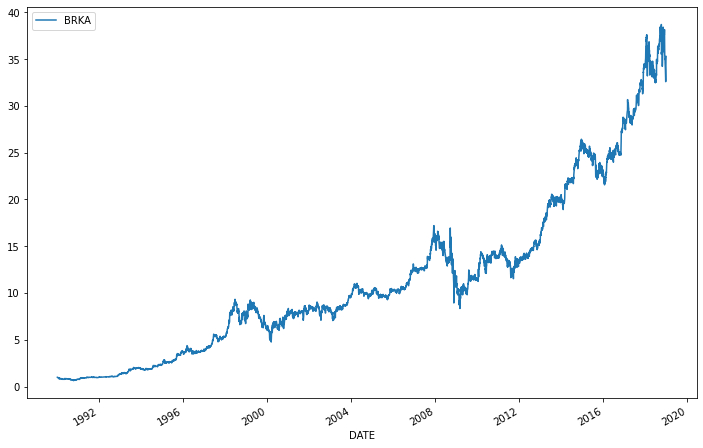

In [5]:
(brka_d+1).cumprod().plot(figsize = (12,8))

In [6]:
def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

def compound_2(r):
    return (r+1).cumprod()

In [7]:
brka_m = brka_d.resample('M').apply(compound).to_period('M')
brka_m

,BRKA
DATE,
1990-01,-0.140634
1990-02,-0.030852
1990-03,-0.069204
1990-04,-0.003717
1990-05,0.067164
...,...
2018-08,0.047256
2018-09,0.013300
2018-10,-0.038422


In [29]:
brka_m.to_csv('./data/brka_m.csv')

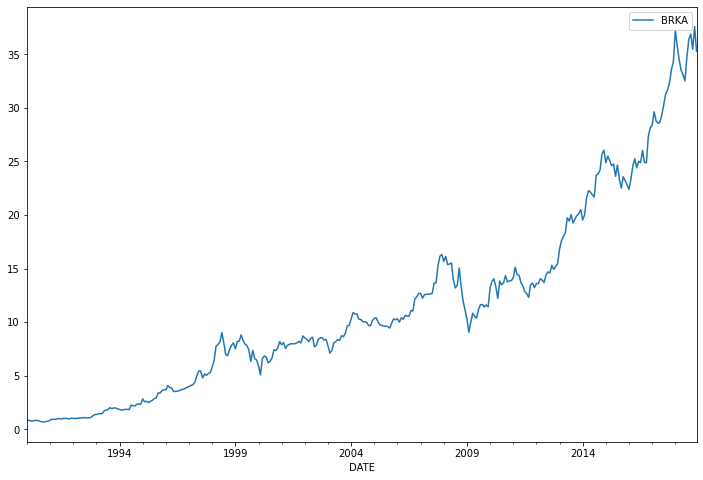

In [9]:
(brka_m+1).cumprod().plot(figsize = (12,8))

In [10]:
def get_fff_returns():
    """
    Load the Fama-French Research Factor Monthly Dataset
    Mkt-Rf = market - risk free
    SMB = Small - Big
    HML = Hight - Low
    """
    rets = pd.read_csv("./data/F-F_Research_Data_Factors_m.csv",
                       header=0, index_col=0, na_values=-99.99)/100
    rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')
    return rets

In [44]:
fff = get_fff_returns()
fff.head()

,Mkt-RF,SMB,HML,RF
1926-07,0.0296,-0.0230,-0.0287,0.0022
1926-08,0.0264,-0.0140,0.0419,0.0025
1926-09,0.0036,-0.0132,0.0001,0.0023
1926-10,-0.0324,0.0004,0.0051,0.0032
1926-11,0.0253,-0.0020,-0.0035,0.0031


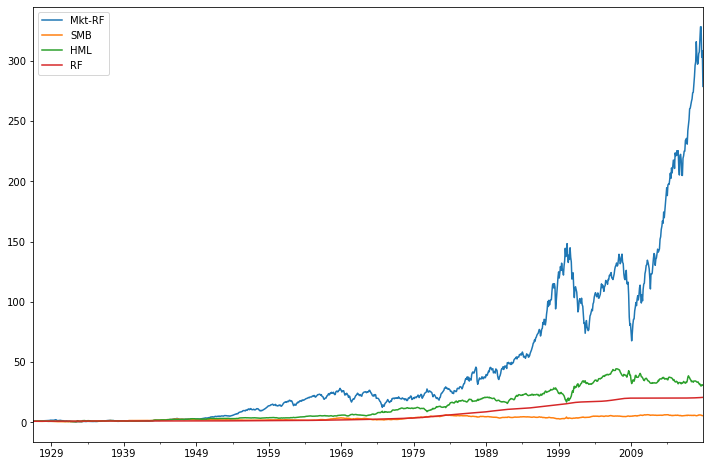

In [12]:
(fff+1).cumprod().plot(figsize = (12,8))

Next, we need to decompose the observed BRKA 1990-May 2012 as in Ang(2014) into the portion that's due to the market and the rest that is not due to the market, using the CAPM as the explanatory model.

i.e.

$$ R_{brka,t} - R_{f,t} = \alpha + \beta(R_{mkt,t} - R_{f,t}) + \epsilon_t $$

We can use the `stats.api` for the linear regression as follows:

In [47]:
### rf= risk free
import statsmodels.api as sm
import numpy as np
brka_excess = brka_m["1990":"2012-05"] - fff.loc["1990":"2012-05", ['RF']].values
mkt_excess = fff.loc["1990":"2012-05",['Mkt-RF']]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
lm = sm.OLS(brka_excess, exp_var).fit() # Ordinary Least Squares

In [48]:
exp_var

,Mkt-RF,Constant
1990-01,-0.0785,1
1990-02,0.0111,1
1990-03,0.0183,1
1990-04,-0.0336,1
1990-05,0.0842,1
...,...,...
2012-01,0.0505,1
2012-02,0.0442,1
2012-03,0.0311,1
2012-04,-0.0085,1


In [23]:
lm.summary()
#constant = alfa
#B = Mkr-RF

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     48.45
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           2.62e-11
Time:                        20:43:34   Log-Likelihood:                 388.47
No. Observations:                 269   AIC:                            -772.9
Df Residuals:                     267   BIC:                            -765.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5402      0.078      6.961      0.000       0.387       0.693
Constant       0.0061      0.004      1.744      0.082      -0.001       0.013
==============================================================================
Omnibus:                       45.698   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.573
Skew:                           0.825   Prob(JB):                     5.33e-23
Kurtosis:                       5.535   Cond. No.                         22.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### The CAPM benchmark interpretation

This implies that the CAPM benchmark consists of 46 cents in T-Bills and 54 cents in the market. i.e. each dollar in the Berkshire Hathaway portfolio is equivalent to 46 cents in T-Bills and 54 cents in the market. Relative to this, the Berkshire Hathaway is adding (i.e. has $\alpha$ of) 0.61% _(per month!)_ although the degree of statistica significance is not very high.

Now, let's add in some additional explanatory variables, namely Value and Size.

In [51]:
exp_var["Value"] = fff.loc["1990":"2012-05",['HML']]
exp_var["Size"] = fff.loc["1990":"2012-05",['SMB']]
exp_var.head()

,Mkt-RF,Constant,Value,Size
1990-01,-0.0785,1,0.0087,-0.0129
1990-02,0.0111,1,0.0061,0.0103
1990-03,0.0183,1,-0.0290,0.0152
1990-04,-0.0336,1,-0.0255,-0.0050
1990-05,0.0842,1,-0.0374,-0.0257


In [53]:
lm = sm.OLS(brka_excess, exp_var).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BRKA   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     36.06
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           1.41e-19
Time:                        20:02:00   Log-Likelihood:                 412.09
No. Observations:                 269   AIC:                            -816.2
Df Residuals:                     265   BIC:                            -801.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.6761      0.074      9.155      0.000       0.531       0.821
Constant       0.0055      0.003      1.679      0.094      -0.001       0.012
Value          0.3814      0.109      3.508      0.001       0.167       0.595
Size          -0.5023      0.101     -4.962      0.000      -0.702      -0.303
==============================================================================
Omnibus:                       42.261   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.954
Skew:                           0.904   Prob(JB):                     1.75e-15
Kurtosis:                       4.671   Cond. No.                         37.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
lm.params[0]

0.6760772026495854

Value > 0 implies that the BRKA invested more in value stocks

size < 0 implies that BRKA invested more in big stocks

### The Fama-French Benchmark Interpretation

The alpha has fallen from .61% to about 0.55% per month. The loading on the market has moved up from 0.54 to 0.67, which means that adding these new explanatory factors did change things. If we had added irrelevant variables, the loading on the market would be unaffected.

We can interpret the loadings on Value being positive as saying that Hathaway has a significant Value tilt - which should not be a shock to anyone that follows Buffet. Additionally, the negative tilt on size suggests that Hathaway tends to invest in large companies, not small companies.

In other words, Hathaway appears to be a Large Value investor. Of course, you knew this if you followed the company, but the point here is that numbers reveal it!

The new way to interpret each dollar invested in Hathaway is: 67 cents in the market, 33 cents in Bills, 38 cents in Value stocks and short 38 cents in Growth stocks, short 50 cents in SmallCap stocks and long 50 cents in LargeCap stocks. If you did all this, you would still end up underperforming Hathaway by about 55 basis points per month.

We can now add the following code to the toolkit:

```python
import statsmodels.api as sm
def regress(dependent_variable, explanatory_variables, alpha=True):
    """
    Runs a linear regression to decompose the dependent variable into the explanatory variables
    returns an object of type statsmodel's RegressionResults on which you can call
       .summary() to print a full summary
       .params for the coefficients
       .tvalues and .pvalues for the significance levels
       .rsquared_adj and .rsquared for quality of fit
    """
    if alpha:
        explanatory_variables = explanatory_variables.copy()
        explanatory_variables["Alpha"] = 1
    
    lm = sm.OLS(dependent_variable, explanatory_variables).fit()
    return lm
```


## Exercise to the Student

I used this particular period because of the example in Ang (2014). However, I have provided data going up to 2018. Have the results held up? Are Buffet's tilts consistent over time?

### Exericices

In [42]:
ff_dataset = get_fff_returns()
ff_dataset = ff_dataset['1991':'2018']
ff_dataset.shape

(336, 4)

#### importing functions portifolios

In [37]:
def get_ind_file(filetype, weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios files
    Variant is a tuple of (weighting, size) where:
        weighting is one of "ew", "vw"
        number of inds is 30 or 49
    """    
    if filetype == "returns":
        name = f"{weighting}_rets" 
        divisor = 100
    elif filetype == "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype == "size":
        name = "size"
        divisor = 1
    else:
        raise ValueError(f"filetype must be one of: returns, nfirms, size")
    
    ind = pd.read_csv(f"data/ind{n_inds}_m_{name}.csv", header=0, index_col=0, na_values=-99.99)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_returns(weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios Monthly Returns
    """
    return get_ind_file("returns", weighting=weighting, n_inds=n_inds)

def get_ind_nfirms(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    return get_ind_file("nfirms", n_inds=n_inds)

def get_ind_size(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    return get_ind_file("size", n_inds=n_inds)


def get_ind_market_caps(n_inds=30, weights=False):
    """
    Load the industry portfolio data and derive the market caps
    """
    ind_nfirms = get_ind_nfirms(n_inds=n_inds)
    ind_size = get_ind_size(n_inds=n_inds)
    ind_mktcap = ind_nfirms * ind_size
    if weights:
        total_mktcap = ind_mktcap.sum(axis=1)
        ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
        return ind_capweight
    #else
    return ind_mktcap

In [39]:
ind49_rets = get_ind_returns(weighting="vw", n_inds=49)["1991":]

In [45]:
ind49_rets.shape

(336, 49)